<a href="https://colab.research.google.com/github/NickSlm/all-for-one/blob/main/machine-learning/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2024-07-23 14:07:32.313171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 14:07:34.277649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2024-07-23 14:07:34.277918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
INPUT_SHAPE = [32, 32, 3]
BATCH_SIZE = 32
CODINGS_DIM = 100

In [3]:
def load_dataset():
    
    (X_train_full, _), (X_test, _) = keras.datasets.cifar10.load_data()

    X_train = X_train_full[5000:]
    X_val = X_train_full[:5000]
    
    X_train = X_train.astype(np.float32) / 255
    X_val = X_val.astype(np.float32) / 255
    X_test = X_test.astype(np.float32) / 255
    
    X_train_dcgan = X_train.reshape(-1, 32, 32, 3) * 2. -1
    X_val_dcgan = X_val.reshape(-1, 32, 32, 3) * 2. -1
    X_test_dcgan = X_test.reshape(-1, 32, 32, 3) * 2. -1
    
    dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    return dataset

In [4]:
def plot_image(images, n_cols=6):
    images = (images + 1) / 2.0
    n_images = images.shape[0]
    n_rows = n_images // n_cols + 1
    figure = plt.figure(figsize=(n_rows, n_cols))
    for i in range(n_images):
        figure.add_subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [5]:
def discriminator(input_shape):
    
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=INPUT_SHAPE))
    model.add(keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

def generator(latent_dim):
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape=[CODINGS_DIM]))
    model.add(keras.layers.Dense(4*4*128))
    model.add(keras.layers.Reshape([4,4,128]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(3, kernel_size=3, padding="SAME", activation="tanh"))
    
    return model


In [6]:
def gan(generator, discriminator):
    discriminator.trainable = False
    gan = keras.models.Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return gan

In [7]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):  
        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        progbar = keras.utils.Progbar(45000 / batch_size)
        for i, X_batch in enumerate(dataset):
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            progbar.add(1, values=[("d_loss", d_loss), ("g_loss", g_loss)])
            # print(f"Batch {i + 1}/{45000 // batch_size} - d_loss: {d_loss} g_loss: {g_loss}")
        if (epoch + 1) % 10 == 0:
            plot_image(generated_images, 6)

In [8]:
g_model = generator(CODINGS_DIM)
d_model = discriminator(INPUT_SHAPE)

gan_model = gan(g_model, d_model)

dataset = load_dataset()

2024-06-09 14:53:34.492012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 14:53:34.543619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 14:53:34.543674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 14:53:34.544473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

2024-06-09 14:53:37.306349: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 552960000 exceeds 10% of free system memory.



Epoch 1/100


2024-06-09 14:53:37.920459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-06-09 14:53:39.181562: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-09 14:53:39.329404: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc7e2cd3840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 14:53:39.329460: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-06-09 14:53:39.337993: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 14:53:39.450768: I tensorflow/compiler/jit/xla_compilation_cache

1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4594 - g_loss: 1.2344
Epoch 2/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.5197 - g_loss: 1.5418
Epoch 3/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4837 - g_loss: 1.7026
Epoch 4/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4928 - g_loss: 1.6815
Epoch 5/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4695 - g_loss: 1.8747
Epoch 6/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4748 - g_loss: 1.8334
Epoch 7/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4988 - g_loss: 1.7129
Epoch 8/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4981 - g_loss: 1.7283
Epoch 9/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4969 - g_loss: 1.7356
Epoch 10/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4921 - g_loss: 1.7896

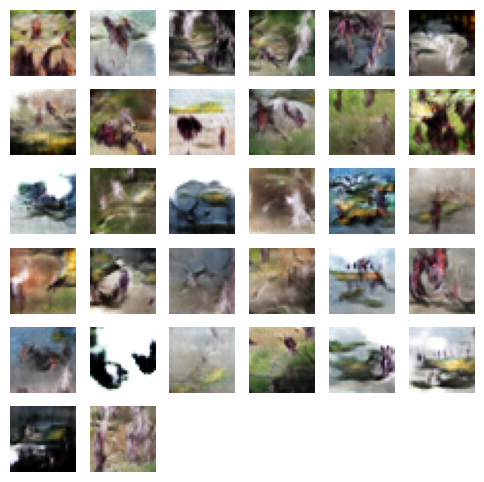


Epoch 11/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4929 - g_loss: 1.7894
Epoch 12/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4852 - g_loss: 1.8544
Epoch 13/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4822 - g_loss: 1.8850
Epoch 14/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4769 - g_loss: 1.9405
Epoch 15/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4699 - g_loss: 1.9956
Epoch 16/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4697 - g_loss: 2.0159
Epoch 17/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4676 - g_loss: 2.0224
Epoch 18/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4594 - g_loss: 2.0739
Epoch 19/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4547 - g_loss: 2.1077
Epoch 20/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4492 - g_loss: 2.1418

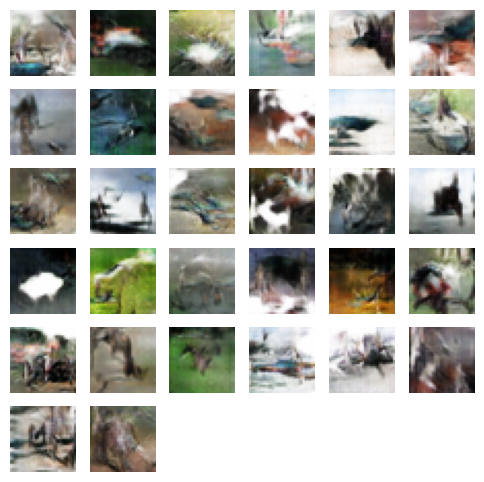


Epoch 21/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4378 - g_loss: 2.2422
Epoch 22/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4342 - g_loss: 2.2603
Epoch 23/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4253 - g_loss: 2.3020
Epoch 24/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4204 - g_loss: 2.3710
Epoch 25/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4210 - g_loss: 2.3599
Epoch 26/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4128 - g_loss: 2.3961
Epoch 27/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4110 - g_loss: 2.4174
Epoch 28/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4095 - g_loss: 2.4169
Epoch 29/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4099 - g_loss: 2.4188
Epoch 30/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4093 - g_loss: 2.4507

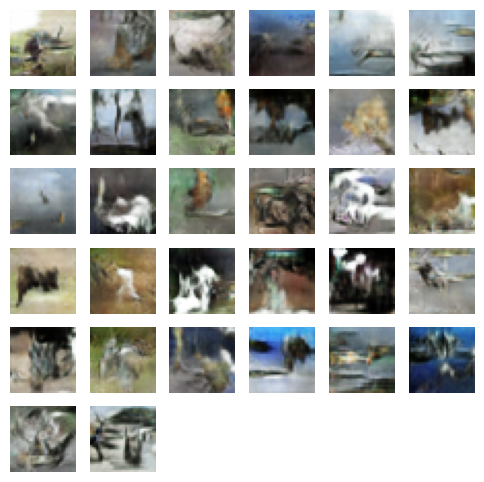


Epoch 31/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4129 - g_loss: 2.4429
Epoch 32/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4020 - g_loss: 2.4785
Epoch 33/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4030 - g_loss: 2.5018
Epoch 34/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4016 - g_loss: 2.5011
Epoch 35/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4001 - g_loss: 2.5175
Epoch 36/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4127 - g_loss: 2.4507
Epoch 37/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4151 - g_loss: 2.4117
Epoch 38/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4193 - g_loss: 2.4155
Epoch 39/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4246 - g_loss: 2.4066
Epoch 40/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4283 - g_loss: 2.3753

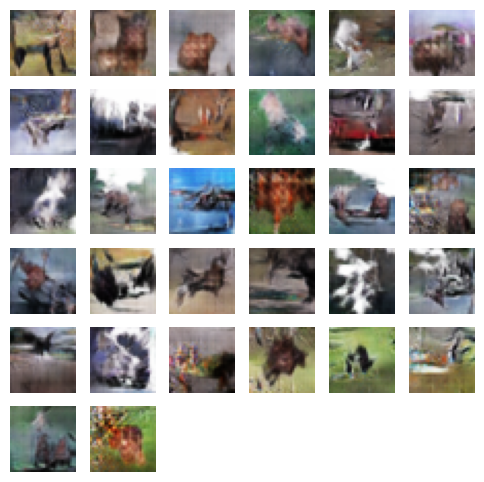


Epoch 41/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4264 - g_loss: 2.3962
Epoch 42/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4242 - g_loss: 2.4042
Epoch 43/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4252 - g_loss: 2.4027
Epoch 44/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4295 - g_loss: 2.3864
Epoch 45/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4300 - g_loss: 2.3685
Epoch 46/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4267 - g_loss: 2.4045
Epoch 47/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4241 - g_loss: 2.4245
Epoch 48/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4272 - g_loss: 2.4142
Epoch 49/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4271 - g_loss: 2.3930
Epoch 50/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4193 - g_loss: 2.4679

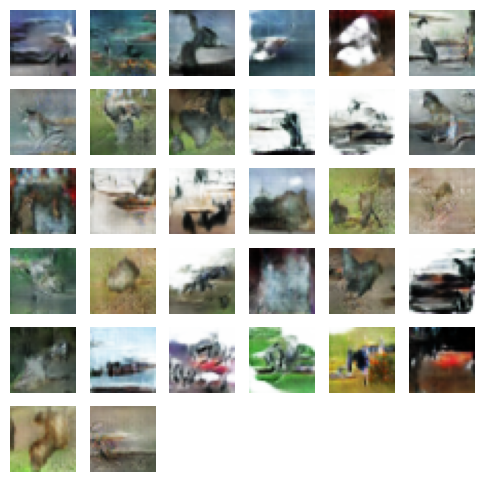


Epoch 51/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4232 - g_loss: 2.4277
Epoch 52/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4184 - g_loss: 2.4691
Epoch 53/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4196 - g_loss: 2.4672
Epoch 54/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4284 - g_loss: 2.4507
Epoch 55/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4158 - g_loss: 2.4918
Epoch 56/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4181 - g_loss: 2.4656
Epoch 57/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4166 - g_loss: 2.5022
Epoch 58/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4171 - g_loss: 2.4889
Epoch 59/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4160 - g_loss: 2.5124
Epoch 60/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4122 - g_loss: 2.5157

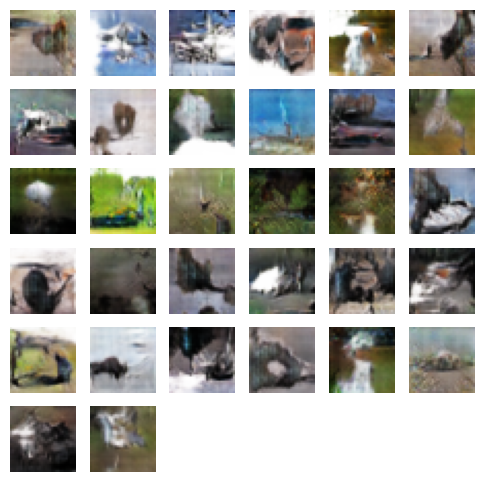


Epoch 61/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4173 - g_loss: 2.4745
Epoch 62/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4163 - g_loss: 2.5229
Epoch 63/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4173 - g_loss: 2.5353
Epoch 64/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4163 - g_loss: 2.5240
Epoch 65/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4155 - g_loss: 2.5609
Epoch 66/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4142 - g_loss: 2.5272
Epoch 67/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4164 - g_loss: 2.5279
Epoch 68/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4117 - g_loss: 2.5728
Epoch 69/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4133 - g_loss: 2.5581
Epoch 70/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4077 - g_loss: 2.5897

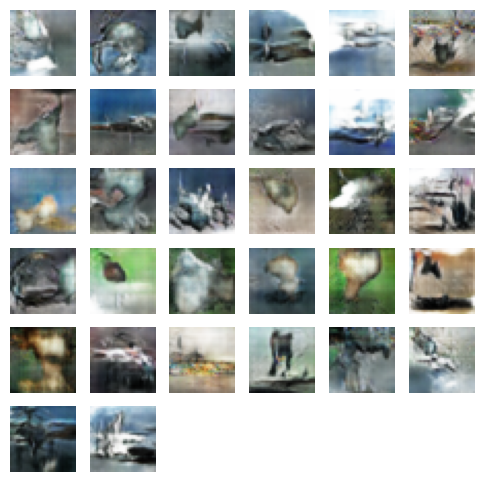


Epoch 71/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4120 - g_loss: 2.5729
Epoch 72/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4053 - g_loss: 2.6085
Epoch 73/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4049 - g_loss: 2.6277
Epoch 74/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4120 - g_loss: 2.5925
Epoch 75/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4048 - g_loss: 2.6086
Epoch 76/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4059 - g_loss: 2.6435
Epoch 77/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4033 - g_loss: 2.6292
Epoch 78/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4018 - g_loss: 2.6443
Epoch 79/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4019 - g_loss: 2.6606
Epoch 80/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4021 - g_loss: 2.6710

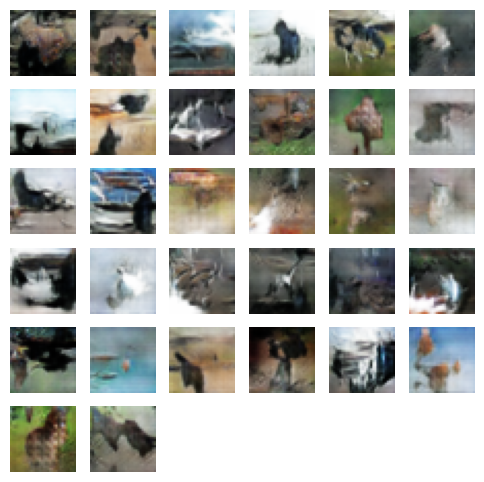


Epoch 81/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4040 - g_loss: 2.6587
Epoch 82/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4024 - g_loss: 2.6501
Epoch 83/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.3996 - g_loss: 2.7057
Epoch 84/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4008 - g_loss: 2.6851
Epoch 85/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4011 - g_loss: 2.6656
Epoch 86/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4071 - g_loss: 2.6423
Epoch 87/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4038 - g_loss: 2.6784
Epoch 88/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4077 - g_loss: 2.6381
Epoch 89/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4021 - g_loss: 2.6959
Epoch 90/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4050 - g_loss: 2.6851

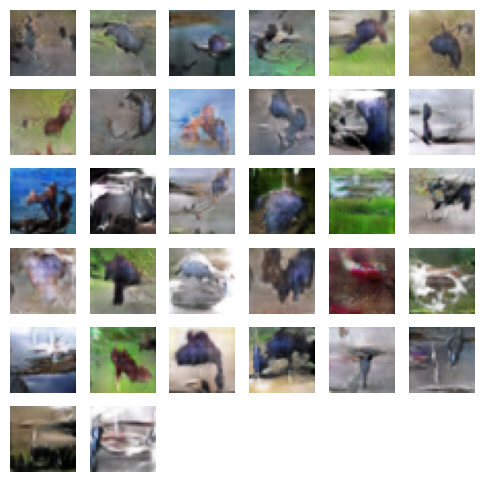


Epoch 91/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4042 - g_loss: 2.6715
Epoch 92/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4026 - g_loss: 2.6846
Epoch 93/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4062 - g_loss: 2.6504
Epoch 94/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4026 - g_loss: 2.6286
Epoch 95/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4013 - g_loss: 2.6859
Epoch 96/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4029 - g_loss: 2.7148
Epoch 97/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4049 - g_loss: 2.7132
Epoch 98/100
1406/1406 [============================>.] - ETA: 0s - d_loss: 0.4052 - g_loss: 2.6929
Epoch 99/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4020 - g_loss: 2.7163
Epoch 100/100
1405/1406 [============================>.] - ETA: 0s - d_loss: 0.4044 - g_loss: 2.675

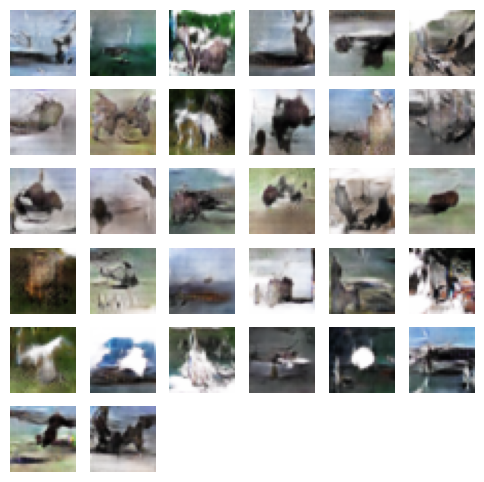

In [9]:
train_gan(gan_model, dataset, 32, 100, 100)

In [5]:
dir_path = "/home/nick/all-for-one/backend/models/models"
file_name = "myGan.h5"
# g_model.save(os.path.join(dir_path, file_name))

In [6]:
gen = keras.models.load_model(os.path.join(dir_path, file_name))

2024-07-23 14:07:45.281480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:07:45.498074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:07:45.498151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:07:45.499778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [13]:
from bson.binary import Binary
import pickle
from PIL import Image

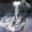

In [31]:
latent_dim = tf.random.normal(shape=[1, 100])
generated_images = gen(latent_dim).numpy()[0]

generated_images = (generated_images + 1) / 2
generated_images = (generated_images * 255).astype(np.uint8)
image = Image.fromarray(generated_images)
image

In [59]:
b_images = Binary(pickle.dumps(generated_images)) 
images = pickle.loads(b_images)


In [60]:
print(images)

[[[[-0.5749524  -0.65183157 -0.80278254]
   [-0.5761371  -0.6475884  -0.7912375 ]
   [-0.740595   -0.76188636 -0.8574439 ]
   ...
   [-0.88718414 -0.9026687  -0.94823503]
   [-0.89062154 -0.90686923 -0.9461948 ]
   [-0.89509577 -0.9071757  -0.9376467 ]]

  [[-0.59995216 -0.6885488  -0.82530296]
   [-0.55364126 -0.6350937  -0.786745  ]
   [-0.7419979  -0.77572525 -0.86413234]
   ...
   [-0.91999966 -0.93952155 -0.96742547]
   [-0.92634547 -0.94223124 -0.9667368 ]
   [-0.9426242  -0.9508785  -0.9675954 ]]

  [[-0.6356406  -0.7128834  -0.8322029 ]
   [-0.6104893  -0.66645885 -0.80389845]
   [-0.7377009  -0.7700896  -0.8602179 ]
   ...
   [-0.88654524 -0.91704637 -0.95388556]
   [-0.9316141  -0.9483172  -0.97071826]
   [-0.9490122  -0.9606407  -0.9740125 ]]

  ...

  [[-0.8620264  -0.79594636 -0.81418765]
   [-0.84203535 -0.75664866 -0.78562534]
   [-0.86696297 -0.808892   -0.81194365]
   ...
   [-0.5053534  -0.4860146  -0.52767235]
   [-0.5469504  -0.5300485  -0.57427216]
   [-0.5999543  